In [1]:
import attention_layer
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Flatten, SimpleRNN, GRU
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional, Conv1D, \
    MaxPooling1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras.layers import concatenate
from keras.utils.vis_utils import plot_model
from helper.dataset_reader import read_tsv
from helper.utils import *
from callback import get_callbacks

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
# input data
merged_data = read_tsv('../../../dataset/ijelid-batch-1.tsv')

train_data = read_tsv('../../../dataset/split_batch_1/train.tsv')
val_data = read_tsv('../../../dataset/split_batch_1/val.tsv')
test_data = read_tsv('../../../dataset/split_batch_1/test.tsv')

In [4]:
X_word_tr, X_char_tr, y_tr, idx_word_tr, idx_tag_tr = wc_input_converter(merged_data, train_data)
X_word_val, X_char_val, y_val, idx_word_val, idx_tag_val = wc_input_converter(merged_data, val_data)
X_word_ts, X_char_ts, y_ts, idx_word_ts, idx_tag_ts = wc_input_converter(merged_data, test_data)

In [5]:
df = list_to_dataframe(merged_data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [7]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10

In [8]:
def wc_blstm_attention_model(num_words, num_tags, num_char, max_len, max_len_char):
    # word embedding as input
    word_input = Input(shape=(max_len, ))
    word_embd = Embedding(input_dim=num_words + 2, output_dim=50, input_length=max_len, mask_zero=True)(word_input)

    # character embedding as input
    char_input = Input(shape=(max_len, max_len_char, ))
    char_embd = TimeDistributed(Embedding(input_dim=num_char + 2, output_dim = 10,
                                          input_length=max_len_char, mask_zero=True))(char_input)

    # character LSTM to obtain word encodings by characters
    char_encd = TimeDistributed(LSTM(units=64, return_sequences=False, recurrent_activation='sigmoid'))(char_embd)

    # main BLSTM stack
    concate = concatenate([word_embd, char_encd])
    dropout_layer = Dropout(0.3)(concate)
    blstm_layer = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_activation='sigmoid'))(dropout_layer)
    attn_layer = attention_layer.Attention(return_sequences=True)(blstm_layer)
    out = TimeDistributed(Dense(num_tags + 1, activation='softmax'))(attn_layer)
    model = Model([word_input, char_input], out)

    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    return model

In [9]:
model = wc_blstm_attention_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 100, 10, 10)  5570       ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      1344600     ['input_1[0][0]']            

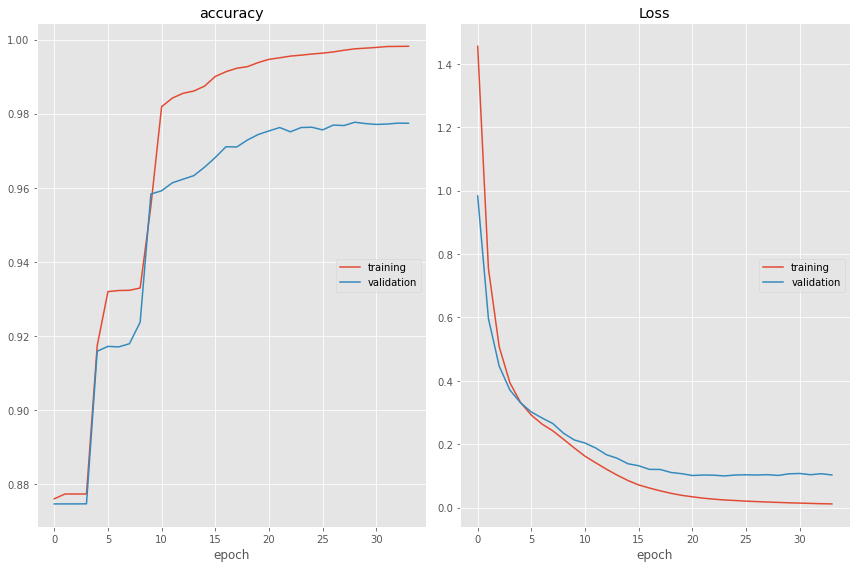

accuracy
	training         	 (min:    0.876, max:    0.998, cur:    0.998)
	validation       	 (min:    0.875, max:    0.978, cur:    0.977)
Loss
	training         	 (min:    0.011, max:    1.456, cur:    0.011)
	validation       	 (min:    0.100, max:    0.983, cur:    0.103)

Epoch 34: val_loss did not improve from 0.09975
56/56 [==============================] - 4s 73ms/step - loss: 0.0985 - accuracy: 0.9790
[0.09848407655954361, 0.9789837002754211]


In [10]:
root_path = 'model/'
model_name = 'wc_blstm_attn_model.h5'
num_epoch = 50
#batch_sz = 32
callbacks = get_callbacks(root_path, model_name)

history = model.fit(x=[X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    y=np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    #validation_data=(X_word_val, y_val),
                    validation_data=(
                      [X_word_val, np.array(X_char_val).reshape((len(X_char_val),
                                                                max_len, max_len_char))],
                        np.array(y_val).reshape(len(y_val), max_len, 1)
                    ),
                    #batch_size=batch_sz,
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose=1
                    )

print(model.evaluate([X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))], np.array(y_ts).reshape(len(y_ts), max_len, 1)))

In [12]:
predict_val = [X_word_ts, np.array(X_char_ts).reshape((len(X_char_ts), max_len, max_len_char))]

i = np.random.randint(0, X_word_ts.shape[0])
p = model.predict(predict_val)

p = np.argmax(p[i], axis=-1)
y_true = y_ts[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_ts[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))

Word                          True      	 Pred

------------------------------------------------------------
@kang_shopee                  O         	O
Makasih                       ID        	ID
bnyk                          ID        	ID
kak                           ID        	ID
udah                          ID        	ID
ngadain                       ID        	ID
GA                            EN        	ID
🥰                             O         	O
semangat                      ID        	ID
buat                          ID        	ID
kakak                         ID        	ID
,                             O         	O
kalo                          ID        	ID
cape                          ID        	ID
gapapa                        ID        	ID
istirahat                     ID        	ID
sebentar                      ID        	ID
,                             O         	O
kalo                          ID        	ID
sedih                         ID        	ID
nangis         

In [14]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_ts)):
    p = model.predict([X_word_ts,
                        np.array(X_char_ts).reshape((len(X_char_ts),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_ts[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_ts[i], y_true, p):
        if w != 0:
            print("{:30}{:10}\t{}".format(idx_word_ts[w], idx_tag_ts[true], idx_tag_ts[pred]))
            w_pair.append(idx_word_ts[w])
            true_pair.append(idx_tag_ts[true])
            pred_pair.append(idx_tag_ts[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

Cara                          ID        	ID
menghilangkan                 ID        	ID
ovt                           EN        	EN
gimana                        ID        	ID
:D                            O         	O
,                             O         	O
walau                         ID        	ID
udh                           ID        	ID
mule                          ID        	ID
teneg                         ID        	ID
tapi                          ID        	ID
ga                            ID        	ID
teneg                         ID        	ID
lagi                          ID        	ID
jadinya                       ID        	ID
(                             O         	O
harusnya                      ID        	ID
ke                            ID        	ID
priv                          EN        	ID
tapi                          ID        	ID
males                         ID        	ID
switch                        EN        	EN
acc                           EN   

In [15]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.9159    0.9535    0.9343     22299
          JV     0.8064    0.9033    0.8521      4910
          EN     0.9470    0.8079    0.8719      5018
   MIX-ID-EN     0.9700    0.8304    0.8948       973
   MIX-ID-JV     0.9915    0.8211    0.8983       285
   MIX-JV-EN     0.9487    0.8014    0.8689       277
           O     0.9526    0.9021    0.9267     10162

   micro avg     0.9148    0.9148    0.9148     43924
   macro avg     0.9332    0.8599    0.8924     43924
weighted avg     0.9176    0.9148    0.9147     43924



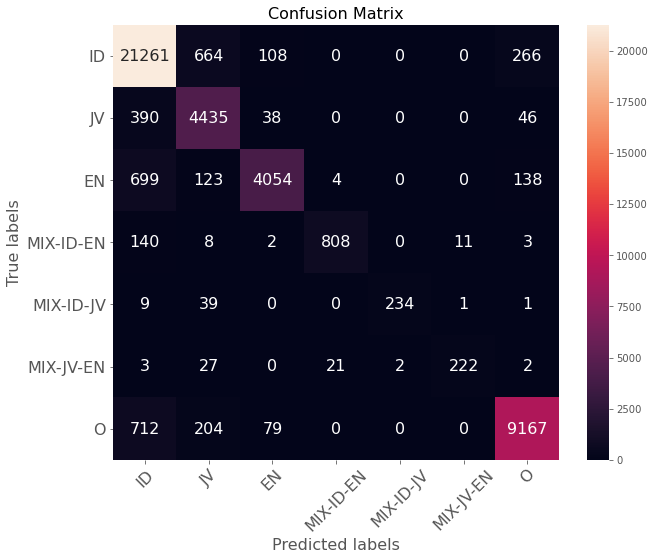

In [16]:
performance_report(true_flat, pred_flat)

In [17]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [18]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [19]:
true_pred_file = 'tagging_result/wc_blstm_attn_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

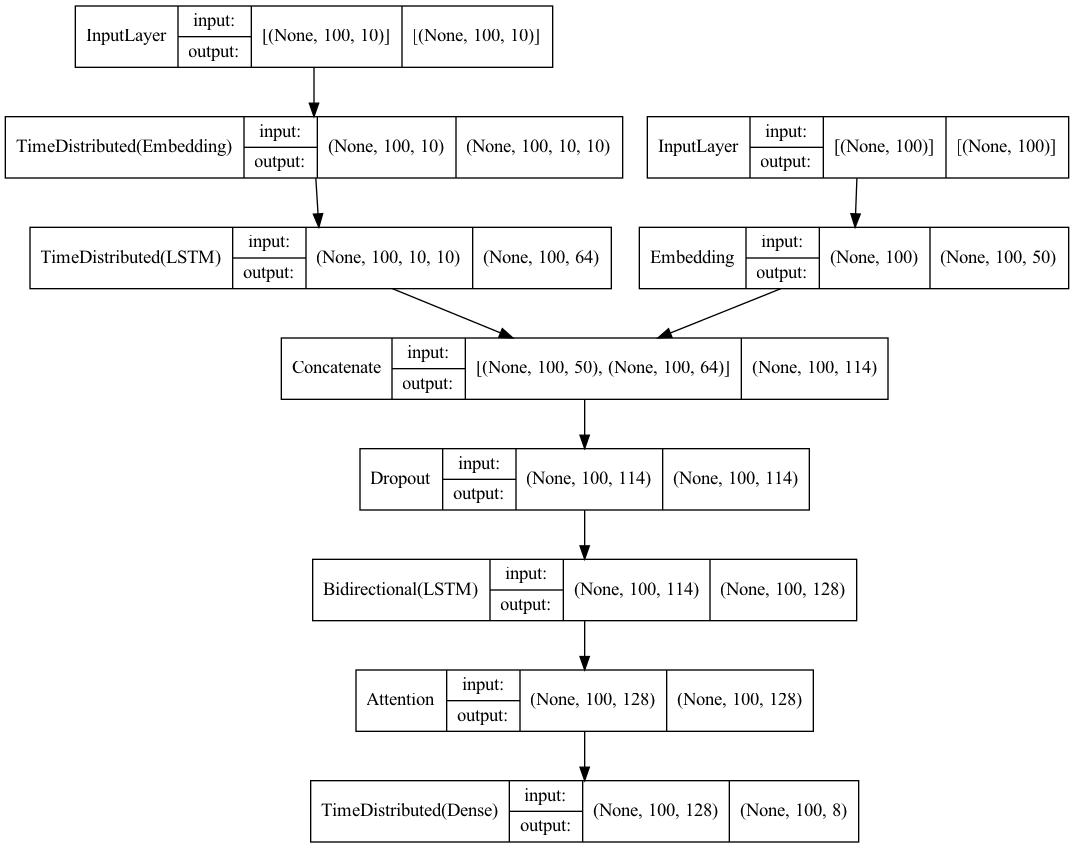

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_wc_blstm_attn.png', show_shapes=True, show_layer_names=False)